# Determine the best features using a Logistic Regression Model

## Imports

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

## Find the git root Directory

In [2]:
# Get the current working directory
cwd = Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

## Import Utils

In [3]:
sys.path.append(f"{root_dir}/utils")

# Seed and Generator for Reproducibility

In [4]:
rnd_val = 0  # Random value for all seeds
rng = np.random.default_rng(seed=rnd_val)  # random number generator

## Define Paths

In [5]:
fig_out_path = Path("figures")
data_path = Path("data")

if not fig_out_path.exists():
    fig_out_path.mkdir()

if not data_path.exists():
    data_path.mkdir()

overall_feature_output_path = f"{fig_out_path}/overall_feature_importances.png"
gene_importances_output_path = f"{fig_out_path}/gene_feature_importances.png"

## Read the calculated dataframes

In [6]:
pos_genes = ["HET", "Null", "WT"]
featdf = pd.read_csv(data_path / "feature_importances.tsv", delimiter="\t")
feat_compartmentsdf = pd.read_csv(
    data_path / "feature_compartments.tsv", delimiter="\t"
)
featdf = pd.merge(featdf, feat_compartmentsdf[["feature", "compartment"]], on="feature")

## Reformat the importances and plot the top features

In [7]:
# The number of features to plot
disp_feat = 10

# Apply the absolute value to each gene columns
absfeatdf = featdf[pos_genes].apply(lambda x: x.abs())

# Calculate the mean of the feature importances across genotype
featdf["Overall"] = absfeatdf.mean(axis=1)

# Find the top mean feature importances
featdf = featdf.sort_values("Overall", ascending=False)

# From the top features select the top n
best_features = featdf[:10]["feature"].tolist()

# Include the mean feature importance in the plot
pos_genes.append("Overall")

# Restructure the data based on feature importance categories
featdf = featdf.melt(
    value_vars=pos_genes,
    id_vars=["feature", "compartment"],
    value_name="importance",
    var_name="genotype",
)

# Select the top features for ploting in the restructured data
feat_filt = featdf["feature"].isin(best_features)
featdf_barplot = featdf[feat_filt]

## Plot the most important HET features

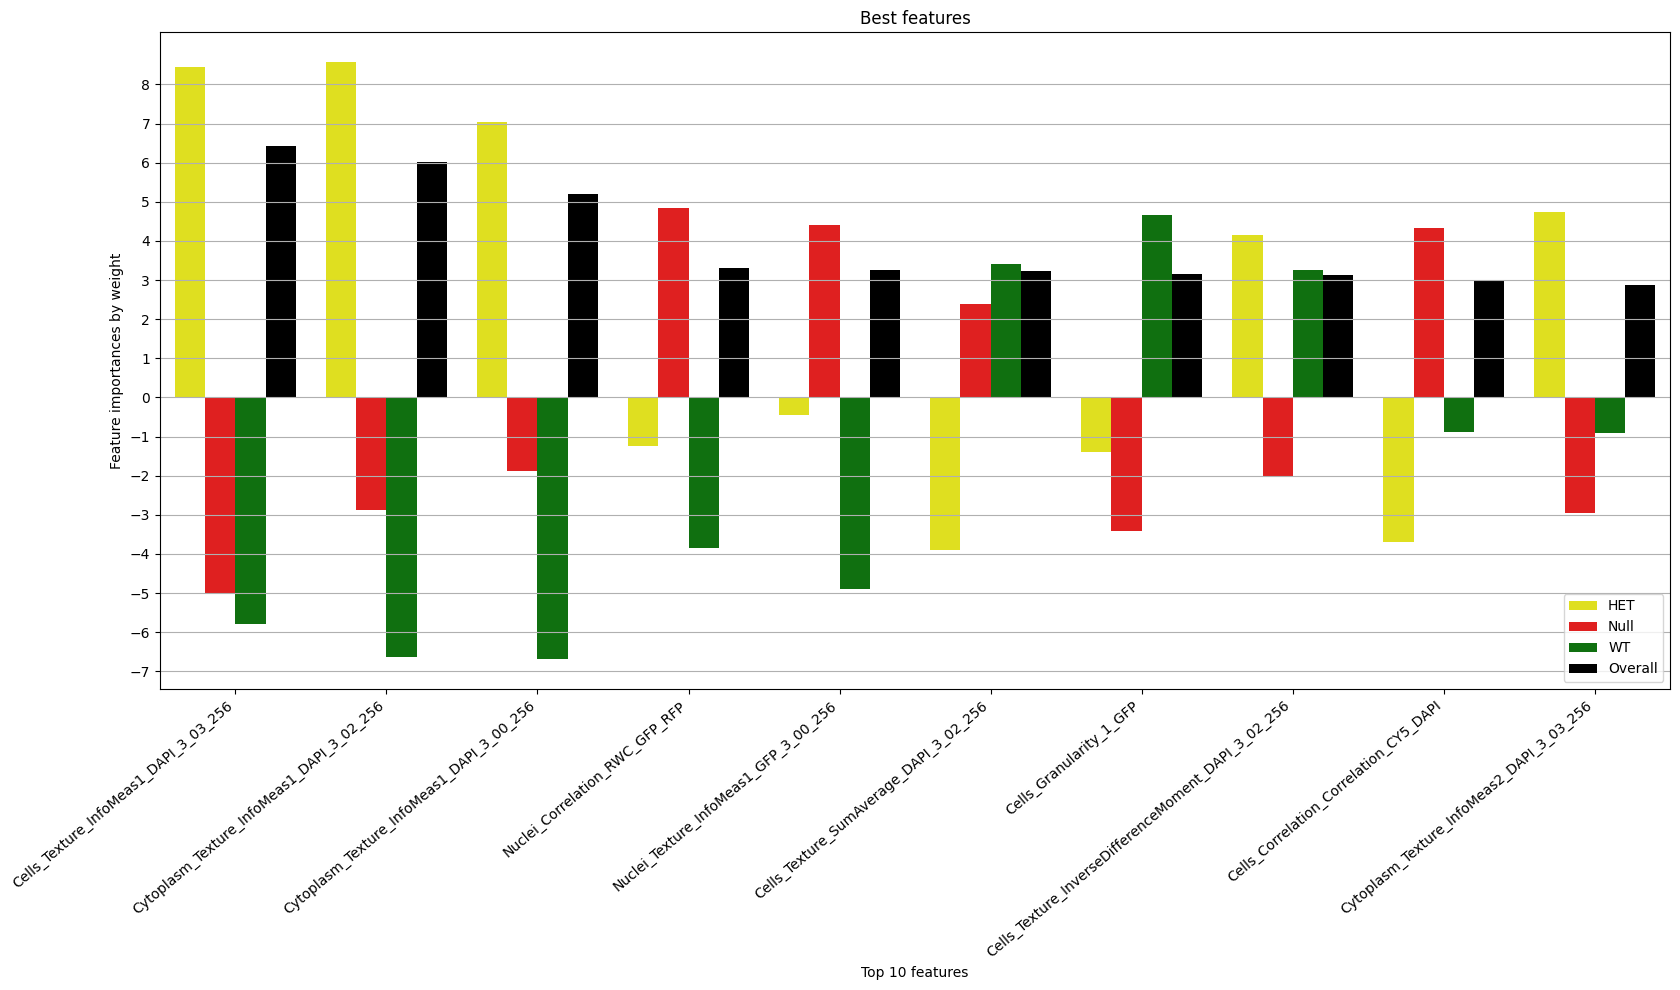

In [8]:
color_palette = ["yellow", "red", "green", "black"]
plt.figure(figsize=(17, 10))
ax = sns.barplot(
    data=featdf_barplot,
    x="feature",
    y="importance",
    hue="genotype",
    palette=color_palette,
)
ax.set_xticklabels(featdf_barplot["feature"].unique().tolist(), rotation=40, ha="right")
ax.grid(True, axis="y")

# The number of features to display
num_ticks = 10

y_values = np.arange(-7, 9, 1).tolist()
plt.yticks(y_values)
plt.ylabel("Feature importances by weight")
plt.xlabel(f"Top {disp_feat} features")
plt.title(f"Best features")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(overall_feature_output_path)

## Feature importances per genotype

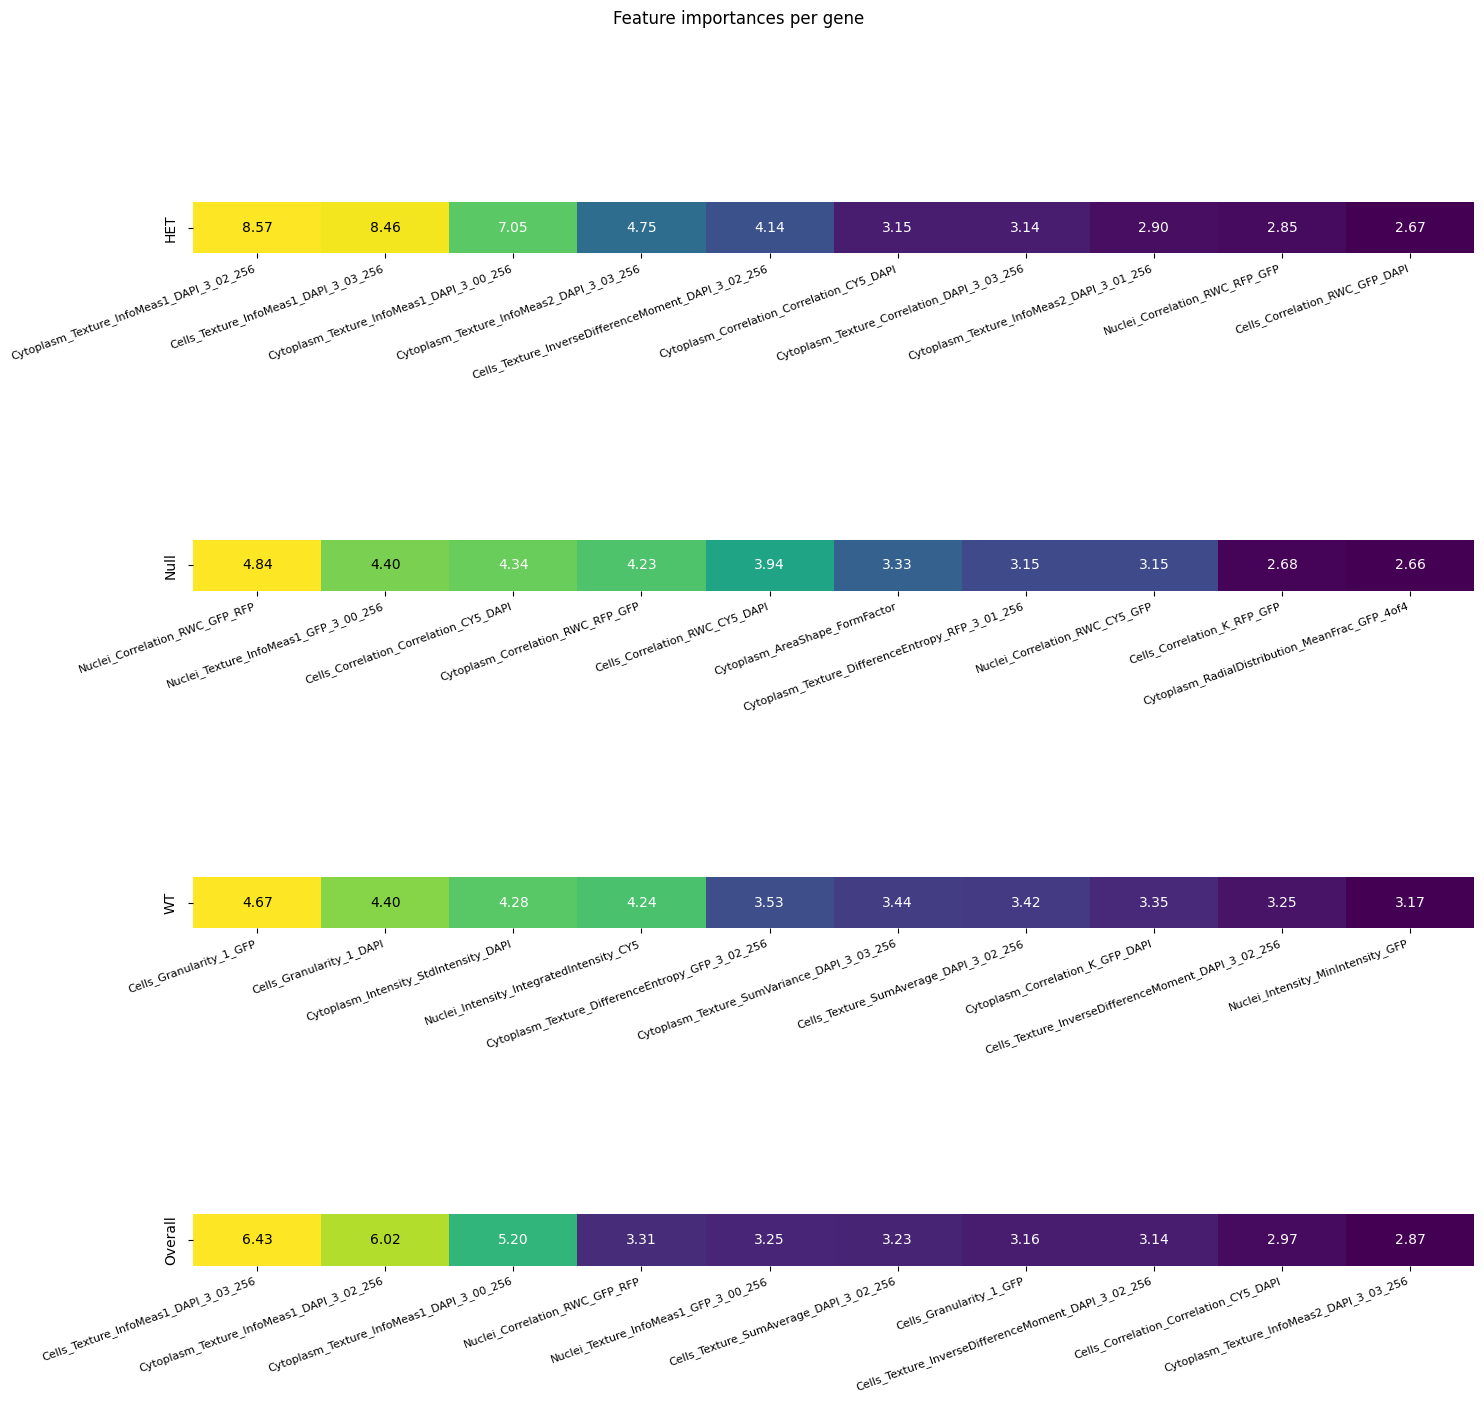

In [9]:
# The number of features to display
number_features = 10

fig, axes = plt.subplots(nrows=len(pos_genes), figsize=(15, 15))

# Iterate through each genotype
for i, gene in enumerate(pos_genes):
    overall_filt = featdf["genotype"] == gene
    df = featdf.loc[overall_filt].sort_values("importance", ascending=False)[
        :number_features
    ]
    ax = sns.heatmap([df["importance"]], ax=axes[i], cmap="viridis", cbar=False)
    ax.set_yticklabels([])  # Remove y-axis tick labels
    ax.set_ylabel(gene)  # Set y-axis label for each row
    ax.set_xticklabels(df["feature"].tolist(), fontsize=8, rotation=20, ha="right")
    ax.set_aspect(0.4)
    quar = df["importance"].quantile(q=0.85)

    # Annotate each cell with the corresponding feature importance
    for j, (idx, row) in enumerate(df.iterrows()):
        text_color = "white" if row["importance"] < quar else "black"
        ax.text(
            j + 0.5,
            0.5,
            f"{row['importance']:.2f}",
            ha="center",
            va="center",
            color=text_color,
        )

fig.suptitle(f"Feature importances per gene")
plt.tight_layout()
plt.savefig(gene_importances_output_path)

## Plot feature importances per compartment for each genotype

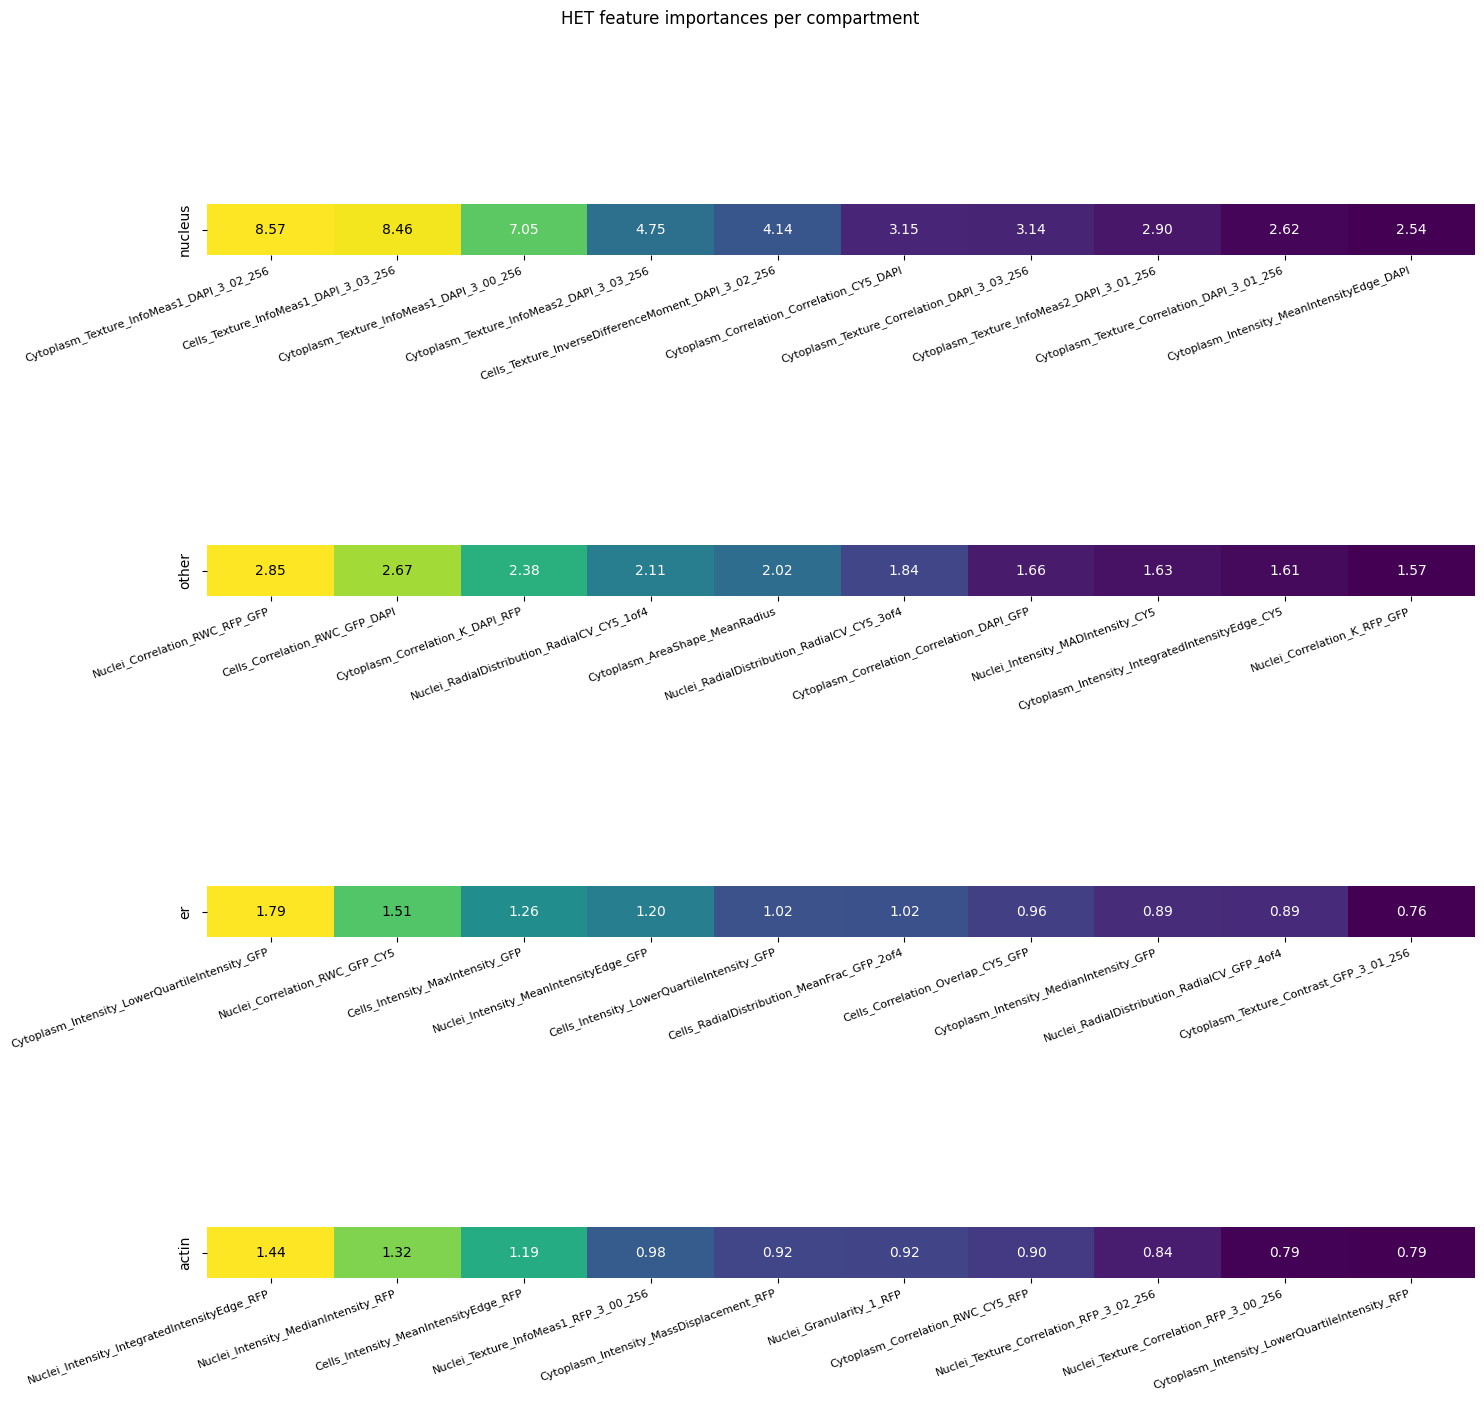

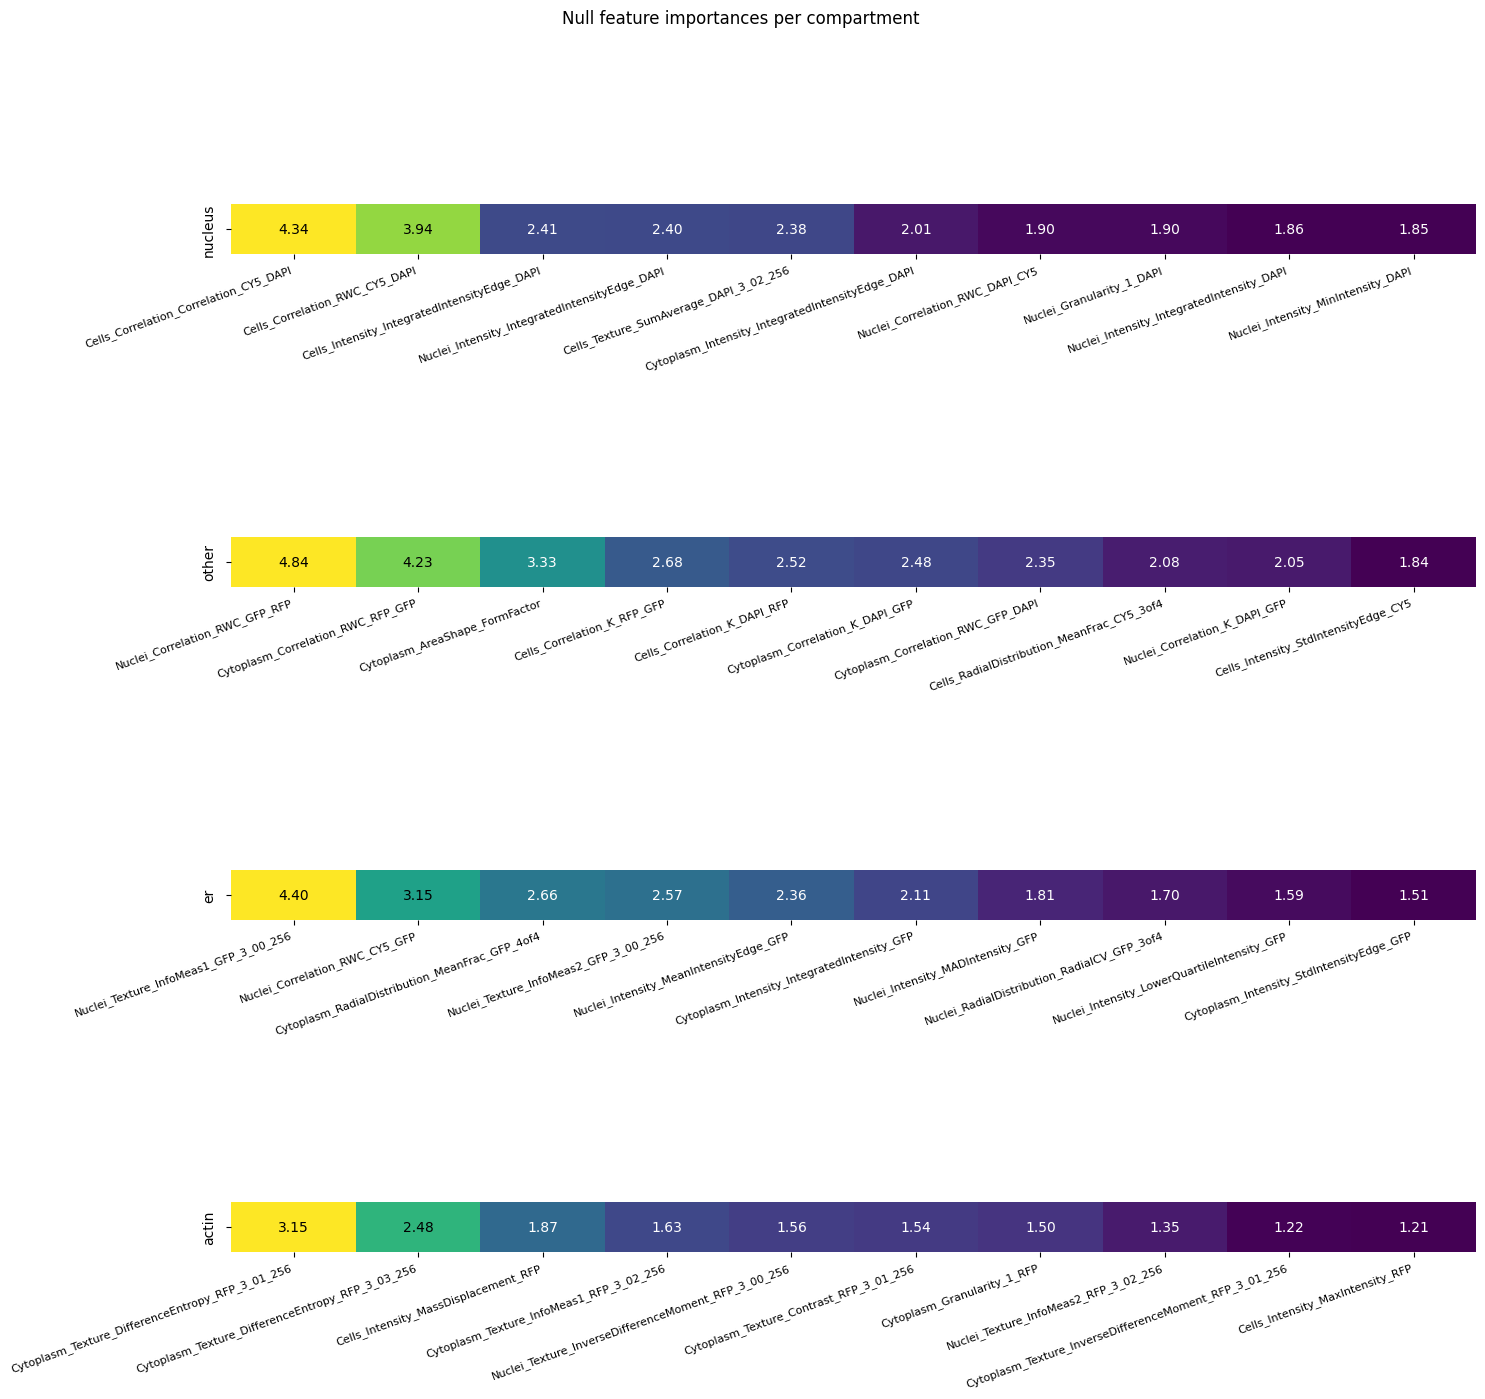

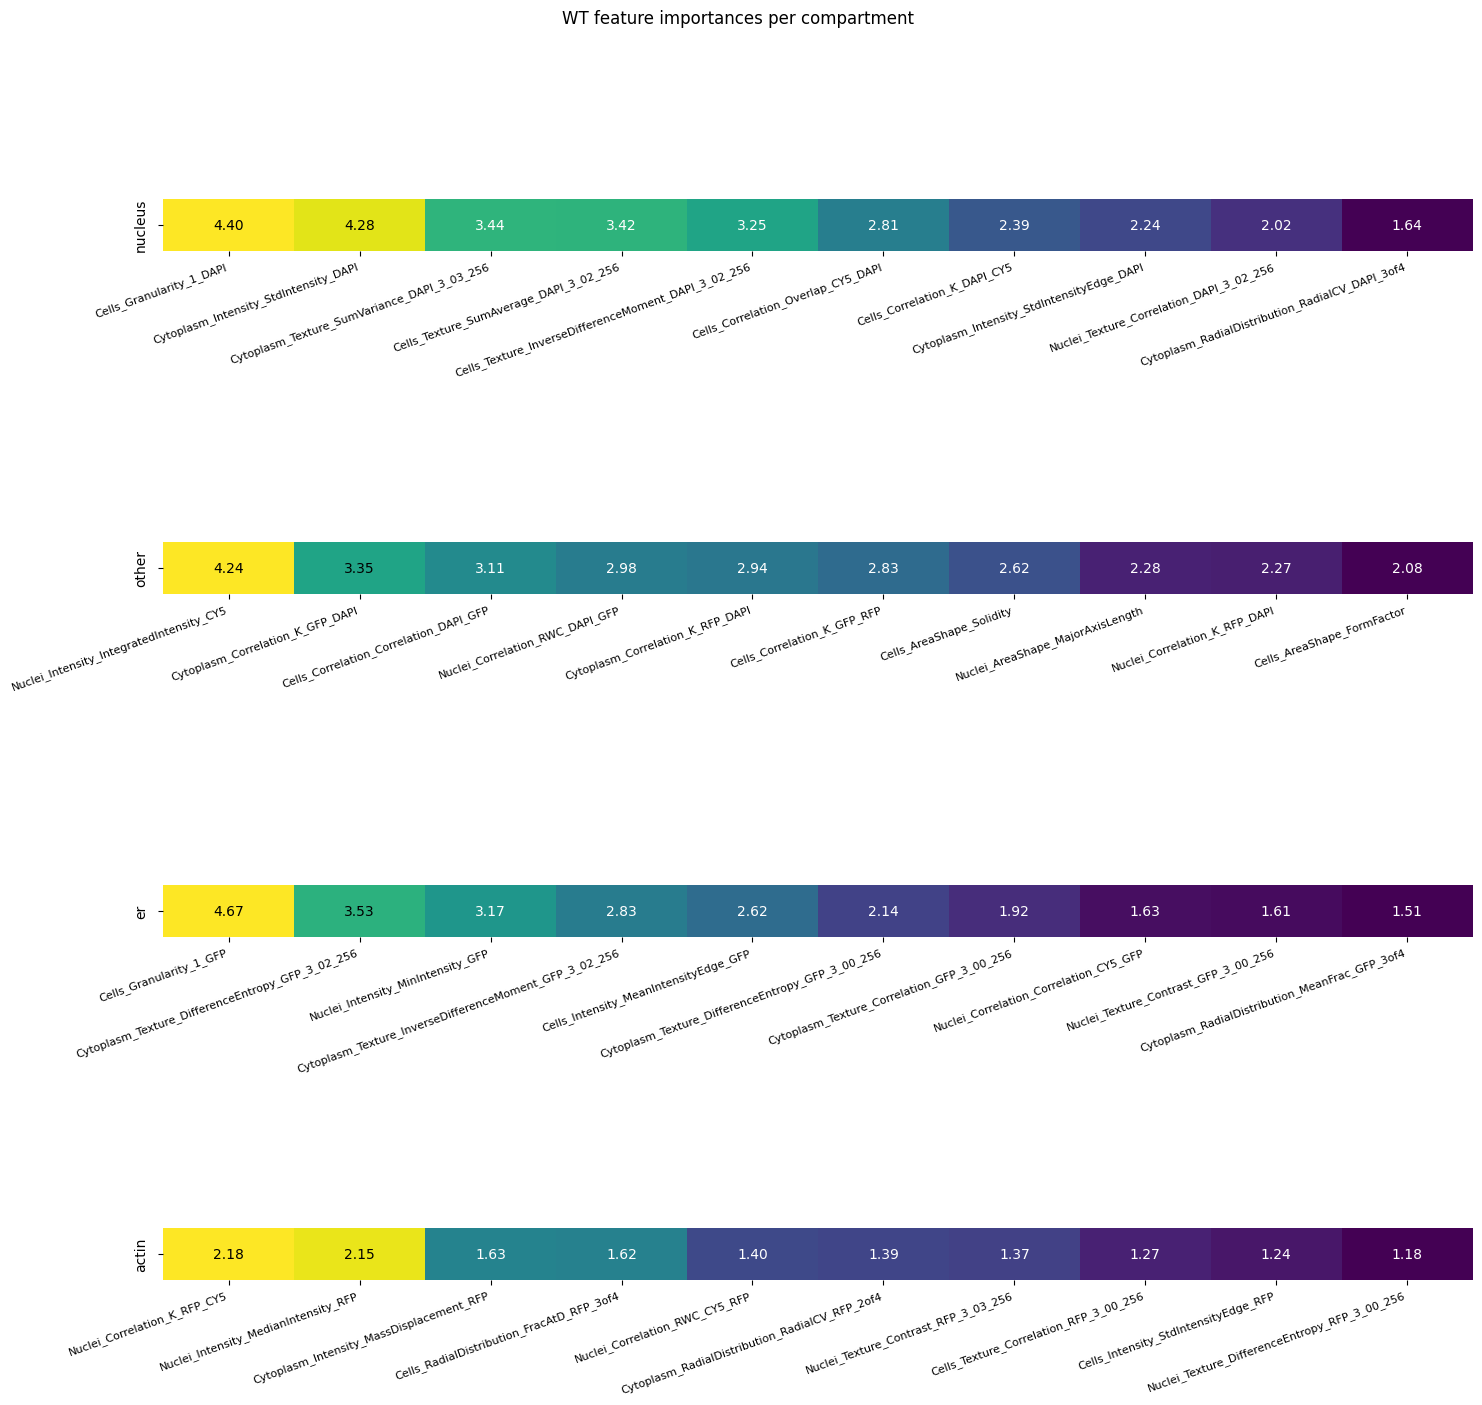

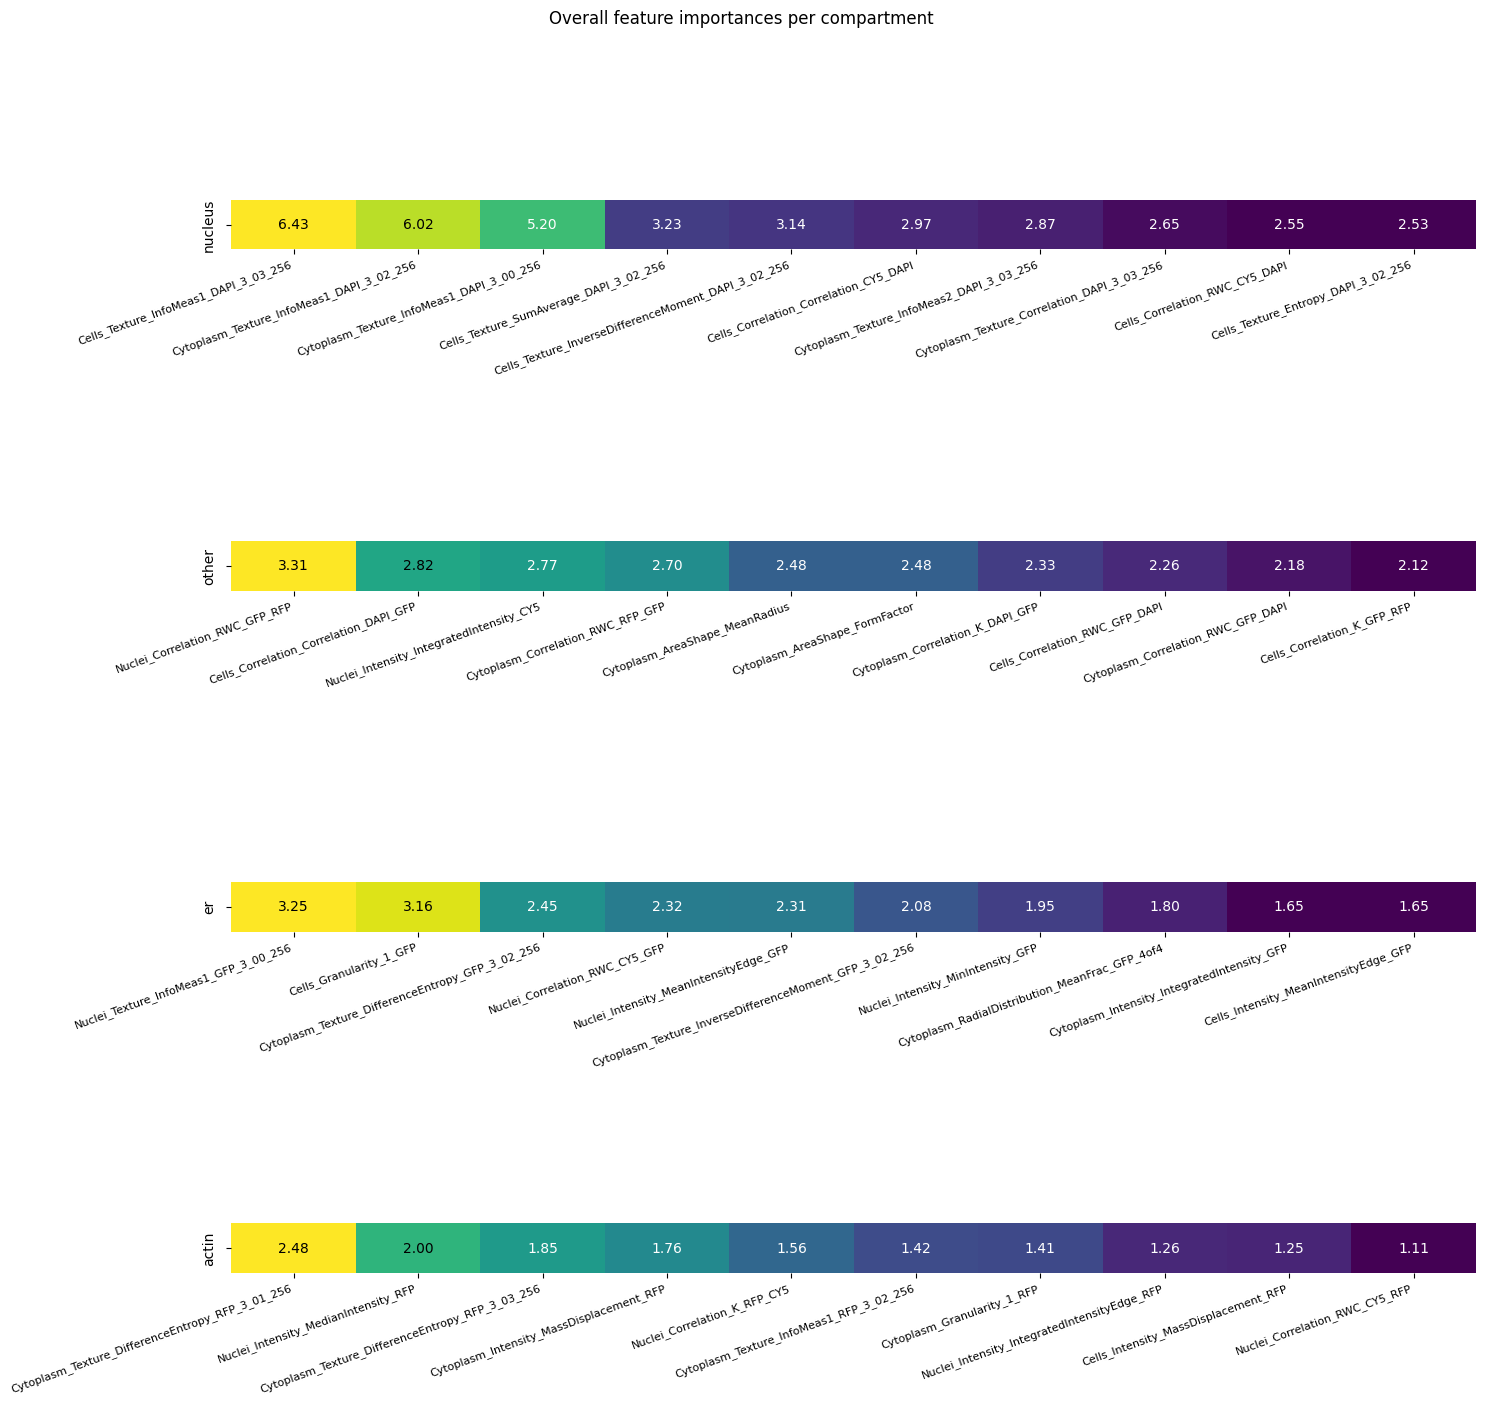

In [10]:
# Create a grid of subplots
pos_compartments = featdf["compartment"].unique()

# The number of features to display
number_features = 10

# Iterate through each geneotype
for gene in pos_genes:
    overall_filt = featdf["genotype"] == gene
    fig, axes = plt.subplots(nrows=len(pos_compartments), figsize=(15, 15))

    # Iterate through each compartment
    for i, compartment in enumerate(pos_compartments):
        df = featdf.loc[
            (featdf["compartment"] == compartment) & overall_filt
        ].sort_values("importance", ascending=False)[:number_features]
        ax = sns.heatmap([df["importance"]], ax=axes[i], cmap="viridis", cbar=False)
        ax.set_yticklabels([])  # Remove y-axis tick labels
        ax.set_ylabel(compartment)  # Set y-axis label for each row
        ax.set_xticklabels(df["feature"].tolist(), fontsize=8, rotation=20, ha="right")
        ax.set_aspect(0.4)
        quar = df["importance"].quantile(q=0.85)

        # Annotate each cell with the corresponding feature importance
        for j, (idx, row) in enumerate(df.iterrows()):
            text_color = "white" if row["importance"] < quar else "black"
            ax.text(
                j + 0.5,
                0.5,
                f"{row['importance']:.2f}",
                ha="center",
                va="center",
                color=text_color,
            )

    fig.suptitle(f"{gene} feature importances per compartment")
    plt.tight_layout()
    plt.savefig(f"{fig_out_path}/{gene}_compartment_feature_importances.png")